# Using physics informed neural networks (PINNs) to solve solid mechanics

Copyright 2022 Jungang(Gordon) Chen

### 1. Import necessary packages and set problem specific data
This code runs with TensorFlow version `2.3.0`.
The implementation relies mainly on the scientific computing library [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) and the machine learning library [TensorFlow](https://www.tensorflow.org/).

All computations were performed on an Intel i7 CPU (8th Gen) with 16 GByte DDR3 RAM (2133 MHz) within a couple of minutes.

In [1]:
pip install pyDOE2

  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=94b6ca2da16ed76fbde022f0ad51aa4a2c06ea1e43c9a24d5be37bf87e81cc30
  Stored in directory: c:\users\jungangc\appdata\local\pip\cache\wheels\a7\56\10\2dcc175569666fb8af5c210980eb5833befd399780e71e6749
Successfully built pyDOE2
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from pyDOE2 import lhs

# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Set constants & model parameters
pi = tf.constant(np.pi, dtype=DTYPE)
E = tf.constant(4e11/3, dtype=DTYPE)   # Young's modulus
v = tf.constant(1/3, dtype=DTYPE)       # Poisson's ratio
E = E/1e11
lmda = tf.constant(E*v/(1-2*v)/(1+v), dtype=DTYPE)
mu = tf.constant(E/(2*(1+v)), dtype=DTYPE)
# viscosity = .01/pi
Q = tf.constant(4.0, dtype=DTYPE)

def u_x_ext(x, y):
    utemp = tf.cos(2*pi*x) * tf.sin(pi*(y))
    return utemp
def u_y_ext(x, y):
    utemp = tf.sin(pi*x) * Q/4*tf.pow(y,4)
    return utemp
def f_x_ext(x,y):
    # gtemp = lmda*(-4*np.power(pi,2)*np.cos(2*pi*x)*np.sin(pi*y)+pi*np.cos(pi*x)*Q*np.power(y,3))+\
    #         mu*(-9*np.power(pi,2)*np.cos(2*pi*x)*np.sin(pi*y)+pi*np.cos(pi*x)*Q*np.power(y,3))
    gtemp = 1.0*(-4*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))+\
            0.5*(-9*tf.pow(pi,2)*tf.cos(2*pi*x)*tf.sin(pi*y)+pi*tf.cos(pi*x)*Q*tf.pow(y,3))
    return gtemp
def f_y_ext(x,y):
    # gtemp = lmda*(3*np.sin(pi*x)*Q*np.power(y,2)-2*np.power(pi,2)*np.sin(2*pi*x)*np.cos(pi*y))+\
    #         mu*(6*np.sin(pi*x)*Q*np.power(y,2)-2*np.power(pi,2)*np.sin(2*pi*x)*np.cos(pi*y)-np.power(pi,2)*np.sin(pi*x)*Q*np.power(y,4)/4)
    gtemp = lmda*(3*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y))+\
            mu*(6*tf.sin(pi*x)*Q*tf.pow(y,2)-2*tf.pow(pi,2)*tf.sin(2*pi*x)*tf.cos(pi*y)-tf.pow(pi,2)*tf.sin(pi*x)*Q*tf.pow(y,4)/4)
    return gtemp

In [3]:
# Define boundary conditions at top 
def fun_b_yy(x, y):
    return (lmda+2*mu)*Q*tf.sin(pi*x)
    # return (lmda+2*mu)*Q*np.sin(pi*x)

In [4]:
pi

<tf.Tensor: shape=(), dtype=float64, numpy=3.141592653589793>

### 2. Generate a set of collocation points


In [5]:
# Set number of data points
# N_0 = 50
N_bound = 50
N_r = 1000

# Set boundary
xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.

# Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

###########################################################################
# Boundary points
x_up = lhs(1,samples=N_bound,random_state=123)
y_up = np.empty(len(x_up))[:,None]
y_up.fill(1)
b_up = np.empty([len(x_up),2])
print(b_up.shape)
b_up[:,0,None] = u_x_ext(x_up, y_up)
b_up[:,1,None] = u_y_ext(x_up, y_up)
x_up_train = np.hstack((x_up, y_up))
# ux_up_train = b_up[:,0, None] 
# uy_up_train = b_up[:,1, None] 
ux_up_train = np.zeros([len(x_up),1])
Syy_up_train = fun_b_yy(x_up, y_up)

x_lo = lhs(1,samples=N_bound,random_state=123)
y_lo = np.empty(len(x_lo))[:,None]
y_lo.fill(0)
b_lo = np.empty([len(x_lo),2])
b_lo[:,0, None] = u_x_ext(x_lo, y_lo)
b_lo[:,1, None] = u_y_ext(x_lo, y_lo)
x_lo_train = np.hstack((x_lo, y_lo))
# ux_lo_train = b_lo[:,0, None] 
# uy_lo_train = b_lo[:,1, None] 
ux_lo_train = np.zeros([len(x_lo),1])
uy_lo_train = np.zeros([len(x_lo),1])

y_ri = lhs(1,samples=N_bound,random_state=123)
x_ri = np.empty(len(y_ri))[:,None]
x_ri.fill(1)
b_ri = np.empty([len(x_ri),2])
b_ri[:,0, None] = u_x_ext(x_ri, y_ri)
b_ri[:,1, None] = u_y_ext(x_ri, y_ri)
x_ri_train = np.hstack((x_ri, y_ri)) 
# ux_ri_train = b_ri[:,0, None]
# uy_ri_train = b_ri[:,1, None]
uy_ri_train = np.zeros([len(x_ri),1])
Sxx_ri_train = np.zeros([len(x_ri),1])

y_le = lhs(1,samples=N_bound,random_state=123)
x_le = np.empty(len(y_le))[:,None]
x_le.fill(0)
b_le = np.empty([len(x_le),2])
b_le[:,0, None] = u_x_ext(x_le, y_le)
b_le[:,1, None] = u_y_ext(x_le, y_le)
x_le_train = np.hstack((x_le, y_le))
# ux_le_train = b_le[:,0, None]
# uy_le_train = b_le[:,1, None]
uy_le_train = np.zeros([len(x_le),1])
Sxx_le_train = np.zeros([len(x_le),1])

X_b_train = np.concatenate((x_up_train, x_lo_train, x_ri_train, x_le_train))
X_train_list = [x_up_train, x_lo_train, x_ri_train, x_le_train]
# ux_b_train = np.concatenate((ux_up_train, ux_lo_train, ux_ri_train, ux_le_train))
# uy_b_train = np.concatenate((uy_up_train, uy_lo_train, uy_ri_train, uy_le_train))
ux_b_train = np.concatenate((ux_up_train, ux_lo_train))
uy_b_train = np.concatenate((uy_lo_train, uy_ri_train, uy_le_train))
Sxx_b_train = np.concatenate((Sxx_ri_train, Sxx_le_train))
Syy_b_train = Syy_up_train

#########################################################################
# collocation points for PINNs
grid_pt = lhs(2,N_r)
xf = grid_pt[:,0]
yf = grid_pt[:,1]
# ff_x = np.asarray([ f_x_ext(xf[j],yf[j]) for j in range(len(yf))])
# ff_y = np.asarray([ f_y_ext(xf[j],yf[j]) for j in range(len(yf))])
# f_x_train = ff_x
# f_y_train = ff_y
X_col_train = np.hstack((xf[:,None],yf[:,None]))

(50, 2)


In [6]:
uy_b_train.shape

(150, 1)

In [7]:
# x = tf.Variable(X_col_train[:, 0:1], trainable=True)
# y = tf.Variable(X_col_train[:, 1:2], trainable=True)

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

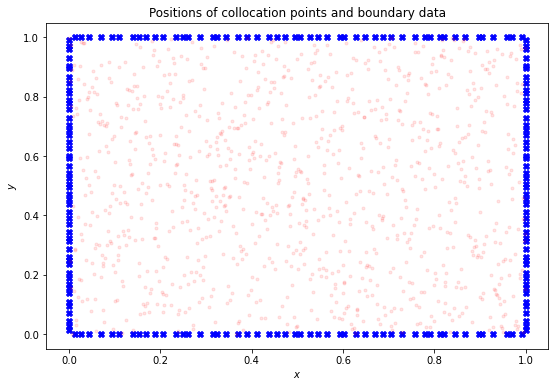

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(X_b_train[:,0], X_b_train[:,1], c='blue', marker='X')
plt.scatter(X_col_train[:,0], X_col_train[:,1], c='r', marker='.', alpha=0.1)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

### 3. Set up network architecture

In [9]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (two spatial dimensions)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))
    
    return model

### 4. Define routines to determine loss and gradient


In [10]:
# Define residual of the PDE in x direction
def fun_r_x(x, y, ux_xx, ux_yy, ux_xy, uy_yy, uy_xx, uy_xy):
    # return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)
    return (lmda+2*mu)*ux_xx+lmda*uy_xy+mu*(ux_yy+uy_xy)-f_x_ext(x,y)
# Define residual of the PDE in y direction
def fun_r_y(x, y, ux_xx, ux_yy, ux_xy, uy_yy, uy_xx, uy_xy):
    return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)
    # return mu*(ux_xy+uy_xx)+(lmda+2*mu)*uy_yy+lmda*ux_xy-f_y_ext(x,y)

def get_r(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = tf.constant(X_col_train[:, 0:1])
    y = tf.constant(X_col_train[:, 1:2])
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        with tf.GradientTape(persistent=True) as tape2:
#             # Variables x and y are watched during tape
#             # to compute derivatives u_t and u_x
            tape2.watch(x)
            tape2.watch(y)
            # Determine residual 
            U = model(tf.stack([x[:,0], y[:,0]], axis=1))
            ux = U[:,0]
            uy = U[:,1]
    #         uy = model(tf.stack([x[:,0], y[:,0]], axis=1))
            # Compute gradient u_x within the GradientTape
            # since we need second derivatives
        duxdx, duxdy = tape2.gradient(ux, (x,y))
        duydx, duydy = tape2.gradient(uy, (x,y))
#         duxdx = tape.gradient(ux, x)
#         duydy = tape.gradient(uy, y)
#         duydx = tape.gradient(uy, x)
#         duxdy = tape.gradient(ux, y)        
    ux_xx = tape1.gradient(duxdx, x)
    ux_yy = tape1.gradient(duxdy, y)
    ux_xy = tape1.gradient(duxdx, y)
    uy_yy = tape1.gradient(duydy, y)
    uy_xx = tape1.gradient(duydx, x)
    uy_xy = tape1.gradient(duydx, y)
    del tape1, tape2
    return fun_r_x(x, y, ux_xx, ux_yy, ux_xy, uy_yy, uy_xx, uy_xy), fun_r_y(x, y, ux_xx, ux_yy, ux_xy, uy_yy, uy_xx, uy_xy)

In [11]:
# boundary condition with fixed displacement (Dirichlet boundary condition)
def fun_b_r_ux(ux_up, ux_lo, ux_b_train):
    # ux_b_temp = tf.stack([ux_up, ux_lo],axis=0)
    return   tf.concat([ux_up, ux_lo], 0)-ux_b_train

def fun_b_r_uy(uy_lo, uy_ri,uy_le, uy_b_train):
    # uy_b_temp = tf.stack([uy_lo, uy_ri, uy_le],axis=0)
    return  tf.concat([uy_lo, uy_ri, uy_le], 0)-uy_b_train

def get_b_r_u(model, X_train_list, ux_b_train, uy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # Split t and x to compute partial derivatives
    x_up, y_up = x_up_train[:, 0:1], x_up_train[:,1:2]
    x_lo, y_lo = x_lo_train[:, 0:1], x_lo_train[:,1:2]
    x_ri, y_ri = x_ri_train[:, 0:1], x_ri_train[:,1:2]
    x_le, y_le = x_le_train[:, 0:1], x_le_train[:,1:2]
    # Determine residual 
    U_up = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))
    ux_up, _ = U_up[:,0], U_up[:,1]
    U_lo = model(tf.stack([x_lo[:,0], y_lo[:,0]], axis=1))
    ux_lo, uy_lo = U_lo[:,0], U_lo[:,1]
    U_ri = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))
    _, uy_ri = U_ri[:,0], U_ri[:,1]
    U_le = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
    _, uy_le = U_le[:,0], U_le[:,1]
    
    return fun_b_r_ux(ux_up, ux_lo, ux_b_train), fun_b_r_uy(uy_lo, uy_ri,uy_le, uy_b_train)

In [12]:
# boundary condition with fixed stress (Neumann boundary condition)
def fun_b_r_Sxx(duxdx_ri,duydy_ri, duxdx_le, duydy_le, Sxx_b_train):
    Sxx_ri = (lmda+2*mu)*duxdx_ri + lmda*duydy_ri
    Sxx_le = (lmda+2*mu)*duxdx_le + lmda*duydy_le
    # Sxx_b_temp = np.concatenate((Sxx_ri, Sxx_le))
    return tf.concat([Sxx_ri,Sxx_le], 0)-Sxx_b_train

def fun_b_r_Syy(duxdx_up, duydy_up, Syy_b_train):
    Syy_b_temp = (lmda+2*mu)*duydy_up + lmda*duxdx_up
    return Syy_b_temp-Syy_b_train

def get_b_r_S(model,X_train_list , Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # A tf.GradientTape is used to compute derivatives in TensorFlow

    x_up = tf.constant(x_up_train[:, 0:1])
    y_up = tf.constant(x_up_train[:, 1:2])
    with tf.GradientTape(persistent=True) as tape:
      # Split t and x to compute partial derivatives

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x_up)
        tape.watch(y_up)

        # Determine residual 
        U_up = model(tf.stack([x_up[:,0], y_up[:,0]], axis=1))
        ux_up = U_up[:,0]
        uy_up = U_up[:,1]

    duxdx_up = tape.gradient(ux_up, x_up)
    duydy_up = tape.gradient(uy_up, y_up)
    del tape
    
    x_ri = tf.constant(x_ri_train[:, 0:1])
    y_ri = tf.constant(x_ri_train[:, 1:2])
    with tf.GradientTape(persistent=True) as tape:
        # x_ri, y_ri = x_ri_train[:, 0:1], x_ri_train[:,1:2]
        tape.watch(x_ri)
        tape.watch(y_ri)
        U_ri = model(tf.stack([x_ri[:,0], y_ri[:,0]], axis=1))
        ux_ri = U_ri[:,0]
        uy_ri = U_ri[:,1]

    duxdx_ri = tape.gradient(ux_ri, x_ri)
    duydy_ri = tape.gradient(uy_ri, y_ri)
    del tape
    
    x_le = tf.constant(x_le_train[:, 0:1])
    y_le = tf.constant(x_le_train[:, 1:2])
    with tf.GradientTape(persistent=True) as tape:
        # x_le, y_le = x_le_train[:, 0:1], x_le_train[:,1:2]
        tape.watch(x_le)
        tape.watch(y_le)
        U_le = model(tf.stack([x_le[:,0], y_le[:,0]], axis=1))
        ux_le = U_le[:,0]
        uy_le = U_le[:,1]

    duxdx_le = tape.gradient(ux_le, x_le)
    duydy_le = tape.gradient(uy_le, y_le)
    del tape
    
    return fun_b_r_Sxx(duxdx_ri,duydy_ri, duxdx_le, duydy_le, Sxx_b_train), fun_b_r_Syy(duxdx_up, duydy_up, Syy_b_train)

## The next function computes the loss for our model


In [13]:
def compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train = X_train_list[0],\
                    X_train_list[1], X_train_list[2], X_train_list[3]
    # Compute phi^r
    rx, ry = get_r(model, X_col_train)
    phi_r = tf.reduce_mean(tf.square(rx)) + tf.reduce_mean(tf.square(ry))
        
    # Compute phi^b
    r_ux, r_uy = get_b_r_u(model, X_train_list, ux_b_train, uy_b_train)
    phi_r_u = tf.reduce_mean(tf.square(r_ux)) + tf.reduce_mean(tf.square(r_uy))
    
    # Compute phi^b
    r_Sxx, r_Syy = get_b_r_S(model, X_train_list, Sxx_b_train, Syy_b_train)
    phi_r_S = tf.reduce_mean(tf.square(r_Sxx)) + tf.reduce_mean(tf.square(r_Syy))
    
    loss = phi_r + phi_r_u + phi_r_S
#     # Add phi^b to the loss
#     for i in range(len(X_data)):
#         u_pred = model(X_data[i])
#         loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [14]:
def get_grad(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function


In [15]:
# Initialize model aka u_\theta
model = init_model()

# model.summary()
# print(model.trainable_variables)
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [16]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_col_train,X_train_list,ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
#     print(i)
    loss = train_step()
    if i==0:
      loss0 = loss
    # Append current loss to hist
    hist.append(loss.numpy()/loss0.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.10202261e+03
It 00050: loss = 1.75571669e+02
It 00100: loss = 3.27230596e+01
It 00150: loss = 9.76664536e+00
It 00200: loss = 1.00850947e+01
It 00250: loss = 5.13499430e+00
It 00300: loss = 3.94852292e+00
It 00350: loss = 8.64673991e+00
It 00400: loss = 4.16675840e+00
It 00450: loss = 2.81842349e+00
It 00500: loss = 1.60440092e+01
It 00550: loss = 2.72966779e+00
It 00600: loss = 4.80360748e+00
It 00650: loss = 2.58186003e+00
It 00700: loss = 4.26537311e+00
It 00750: loss = 3.48312037e+00
It 00800: loss = 4.07296326e+00
It 00850: loss = 9.47293054e+00
It 00900: loss = 2.57356315e+00
It 00950: loss = 1.02607199e+00
It 01000: loss = 3.20105059e+00
It 01050: loss = 4.51869770e-01
It 01100: loss = 4.17943544e-01
It 01150: loss = 4.10612546e-01
It 01200: loss = 4.03763681e-01
It 01250: loss = 3.97226667e-01
It 01300: loss = 3.90921038e-01
It 01350: loss = 3.84801180e-01
It 01400: loss = 3.78838036e-01
It 01450: loss = 3.73011544e-01
It 01500: loss = 3.67306888e-01
It 01550

### Plot solution

C:\Users\jungangc\AppData\Local\Temp/ipykernel_26784/948392387.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(X, Y, Ux, cmap='seismic', vmin=-0.8, vmax=0.8)
C:\Users\jungangc\AppData\Local\Temp/ipykernel_26784/948392387.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(X, Y, Uy, cmap='seismic', vmin=-0.8, vmax=0.8)


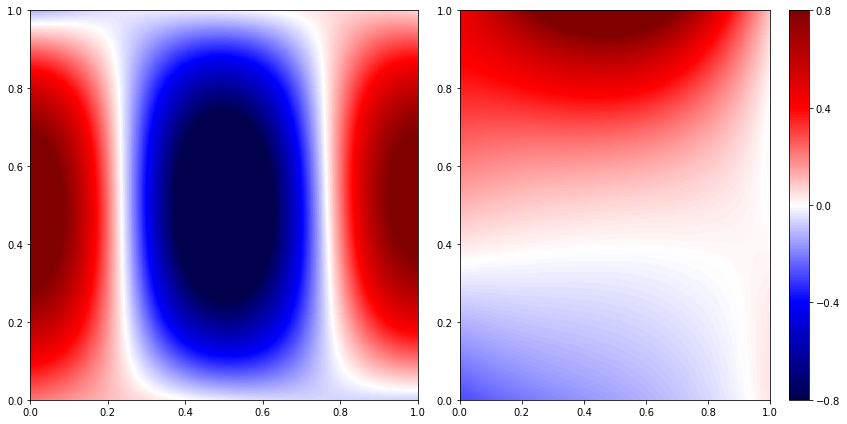

In [17]:

# Set up meshgrid
N = 600
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
Upred = model(tf.cast(Xgrid,DTYPE))
ux_pred = Upred[:,0]
uy_pred = Upred[:,1]

# Reshape upred
Ux = ux_pred.numpy().reshape(N+1,N+1)
Uy = uy_pred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig,ax = plt.subplots(1,2,figsize=(12,6))
im = ax[0].pcolor(X, Y, Ux, cmap='seismic', vmin=-0.8, vmax=0.8)
im = ax[1].pcolor(X, Y, Uy, cmap='seismic', vmin=-0.8, vmax=0.8)
plt.colorbar(im, ticks=np.linspace(-0.8, 0.8, 5))

fig.tight_layout()
plt.show()

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### Plot the evolution of loss

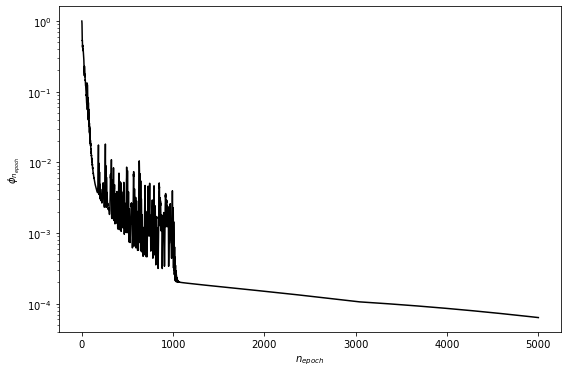

In [18]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

## Class implementation of PINNs

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.